In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import HuberRegressor as hreg
from sklearn.model_selection import cross_validate

from scipy.interpolate import interp1d as spline

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
# tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
tracks = 'TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout|TwoTower_noTimeout|TwoTower_Timeout'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [3]:
morph_rare = ['4139265.3','4139265.4','4139265.5','4222168.1'] #,'4139266.3'] #,'4222175.0']
# morph_familiar = ['4222153.2','4222154.1','4222153.1','4222157.3','4222174.1','4222153.3']
morph_familiar = ['4222153.1','4222153.2','4222153.3','4222174.1','4222154.1']

In [4]:
def sess_lar(sess,max_pos=450,cellmask = None):
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    print(C.shape)
    S=S/1546
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


    effMorph = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter']
    effMorph = (effMorph+.3)/1.6
    rewards = 1.*(trial_info['rewards']>0)

    msort = np.argsort(effMorph)

    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
    S_trial_mat[np.isnan(S_trial_mat)]=0
    posmask = centers<=max_pos
    S_tm = S_trial_mat[:,posmask,:].reshape([S_trial_mat.shape[0],-1])
    S_tm_norm = S_tm/np.linalg.norm(S_tm,ord=2,axis=1)[:,np.newaxis]
   # S_sm = np.matmul(S_tm_norm,S_tm_norm.T)


    lar = np.zeros(effMorph.shape)
    sim0 = np.zeros(effMorph.shape)
    sim1 = np.zeros(effMorph.shape)
    for trial in range(effMorph.shape[0]):
        mask0 = trial_info['morphs']==0
        mask1 = trial_info['morphs']==1
        if trial_info['morphs'][trial]==0:
            mask0[trial]=False
        elif trial_info['morphs'][trial]==1:
            mask1[trial]=False
            
        centroid0, centroid1 = np.nanmean(S_tm[mask0,:],axis=0), np.nanmean(S_tm[mask1,:],axis=0)
        
        centroid0/=np.linalg.norm(centroid0.ravel(),ord=2)
        centroid1/=np.linalg.norm(centroid1.ravel(),ord=2)
        cd = centroid0-centroid1
#         cd/=np.linalg.norm(cd.ravel(),ord=2)
        
        angle0, angle1 = np.dot(S_tm_norm[trial,:],centroid0), np.dot(S_tm_norm[trial,:],centroid1) 
        sim0[trial],sim1[trial] = angle0,angle1
#         print(effMorph[trial],sim0[trial],sim1[trial])
#         lar[trial]= np.log(np.dot(S_tm_norm[trial,:],centroid0)/np.dot(S_tm_norm[trial,:],centroid1))
#         lar[trial] = np.dot(S_tm_norm[trial,:],cd)
        lar[trial]=angle0/(angle0+angle1)
        
    return lar, effMorph, sim0, sim1
        

    

In [5]:
mouse = '4139265.5'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1410,4139265.5,10_02_2019,1,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.5\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...
1412,4139265.5,10_02_2019,3,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.5\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...
1439,4139265.5,12_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.5\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\12_02_2...
1462,4139265.5,15_02_2019,2,TwoTower_foraging,86,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.5\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\15_02_2...
1481,4139265.5,17_02_2019,2,TwoTower_foraging,80,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.5\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\17_02_2...
1501,4139265.5,19_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-19,G:\My Drive\VR_Data\TwoTower\4139265.5\19_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\19_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\19_02_2...
1519,4139265.5,21_02_2019,2,TwoTower_foraging,105,1,CA1,2019-02-21,G:\My Drive\VR_Data\TwoTower\4139265.5\21_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\21_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\21_02_2...
1528,4139265.5,22_02_2019,2,TwoTower_foraging,98,1,CA1,2019-02-22,G:\My Drive\VR_Data\TwoTower\4139265.5\22_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\22_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\22_02_2...
1534,4139265.5,23_02_2019,2,TwoTower_foraging,96,1,CA1,2019-02-23,G:\My Drive\VR_Data\TwoTower\4139265.5\23_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\23_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\23_02_2...
1539,4139265.5,24_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-24,G:\My Drive\VR_Data\TwoTower\4139265.5\24_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\24_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\24_02_2...


In [6]:
sess = df_mouse.iloc[-1]
lar, effMorph, sim0, sim1 = sess_lar(sess)

# VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
# trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


num aberrant ttls 0.0
36583 (36583,) (36583, 21) 124384
(124384,) (124384, 21)


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0
(36583, 1047)


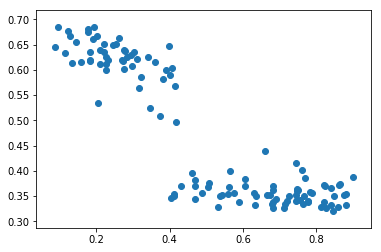

In [7]:
f,ax = plt.subplots()
ax.scatter(effMorph,lar)

In [8]:
def LAR_list_maker(mlist,firstSess = None,max_pos=450.):
    LAR, EM,S0,S1 = {},{},{},{}
    
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for mouse,f_ind in zip(mlist,firstSess): 
        LAR[mouse],EM[mouse],S0[mouse],S1[mouse] = [],[],[],[]
        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0]).tolist()):
            print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
#             print(sess)
            lar, em,s0,s1 = sess_lar(sess,max_pos=max_pos)
            LAR[mouse].append(lar)
            EM[mouse].append(em)
            S0[mouse].append(s0)
            S1[mouse].append(s1)
    return LAR, EM,S0,S1

In [9]:
LAR_rare,EM_rare,S0_rare,S1_rare = LAR_list_maker(morph_rare,firstSess=[5,5,5,3])

session ind 5
num aberrant ttls 0.0
35085 (35085,) (35085, 21) 115307
(115307,) (115307, 21)
frame diff 0
(35085, 1828)
session ind 6
num aberrant ttls 0.0
33140 (33140,) (33140, 21) 109003
(109003,) (109003, 21)
frame diff 0
(33140, 1904)
session ind 7
num aberrant ttls 0.0
38209 (38209,) (38209, 21) 126969
(126969,) (126969, 21)
frame diff 0
(38209, 1817)
session ind 8
num aberrant ttls 0.0
33547 (33547,) (33547, 21) 110218
(110218,) (110218, 21)
frame diff 0
(33547, 1708)
session ind 9
num aberrant ttls 0.0
32038 (32038,) (32038, 21) 105022
(105022,) (105022, 21)
frame diff 0
(32038, 1715)
session ind 5
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
(102093,) (102093, 21)
frame diff 0
(30897, 1632)
session ind 6
num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
(95160,) (95160, 21)
frame diff 0
(29023, 1656)
session ind 7
num aberrant ttls 0.0
31116 (31116,) (31116, 21) 102131
(102131,) (102131, 21)
frame diff 0
(31116, 1515)
session ind 8
num aberrant ttls 0.0
31932 (

In [10]:
LAR_fam,EM_fam,S0_fam,S1_fam = LAR_list_maker(morph_familiar,firstSess=4)

session ind 4
num aberrant ttls 0.0
36036 (36036,) (36036, 21) 118455
(118455,) (118455, 21)
frame diff 0
(36036, 301)
session ind 5
num aberrant ttls 0.0
33778 (33778,) (33778, 21) 111444
(111444,) (111444, 21)
frame diff 0
(33778, 273)
session ind 6
num aberrant ttls 0.0
35977 (35977,) (35977, 21) 118959
(118959,) (118959, 21)
frame diff 0
(35977, 237)
session ind 4
num aberrant ttls 0.0
35248 (35248,) (35248, 21) 116195
(116195,) (116195, 21)
frame diff 0
(35248, 2127)
session ind 5
num aberrant ttls 0.0
33545 (33545,) (33545, 21) 121243
(121243,) (121243, 21)
frame diff 0
(33545, 2149)
session ind 6
num aberrant ttls 0.0
38697 (38697,) (38697, 21) 129389
(129389,) (129389, 21)
frame diff 0
(38697, 2046)
session ind 7
num aberrant ttls 0.0
37344 (37344,) (37344, 21) 121463
(121463,) (121463, 21)
frame diff 0
(37344, 1951)
session ind 4
num aberrant ttls 0.0
22769 (22769,) (22769, 21) 72892
(72892,) (72892, 21)
frame diff 0
(22769, 161)
session ind 5
num aberrant ttls 0.0
13661 (1366

In [11]:

def plot_LAR(LAR,EM,cmap='copper',ymin=-1.2,ymax=1.2):
    cmap = plt.cm.get_cmap(cmap)
    f = plt.figure()
    gs = gridspec.GridSpec(1,5)
    ax_scat = f.add_subplot(gs[:,:4])
    ax_hist = f.add_subplot(gs[:,-1])
    N = len(LAR.keys())
    bins = np.linspace(ymin,ymax)
    print(N)
    for i,mouse in enumerate(LAR.keys()):
        if len(LAR[mouse])>0:
            print(mouse)
            lar,em = np.concatenate(LAR[mouse]),np.concatenate(EM[mouse])
#             lar/=np.amax(lar)-np.amin(lar)
#             lar-=lar.mean()
#             lar/=np.amax(np.abs(lar))
            print(lar.shape)
            ax_scat.scatter(em,lar,color=cmap(np.float(i/N)),alpha=.4,s=8)
            hist,edges = np.histogram(lar,bins=bins)
            ax_hist.fill_betweenx(edges[1:],hist/hist.sum(),color=cmap(np.float(i/N)),alpha=.4)
#             ax_hist.hist(lar,bins=50,orientation='horizontal',color=cmap(np.float(i/N)),alpha=.4,density=True)
    ax_hist.set_ylim([ymin,ymax])
    ax_scat.set_ylim([ymin,ymax])
    ax_hist.set_yticks([])
    return f,(ax_scat,ax_hist)

In [12]:
basedir = "G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\"

4
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4222168.1
(490,)
5
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(140,)
4222174.1
(565,)
4222154.1
(510,)


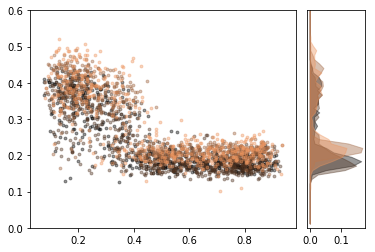

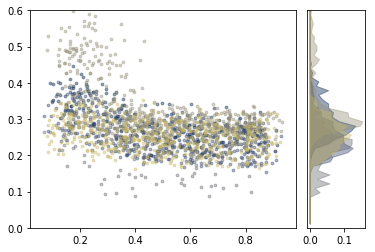

In [13]:
f,ax = plot_LAR(S0_rare,EM_rare,ymin=0,ymax=0.6)
# f.savefig(os.path.join(basedir,'rare_sim0.pdf'),format='pdf')

f,ax = plot_LAR(S0_fam,EM_fam,cmap='cividis',ymin=0,ymax=.6)
# f.savefig(os.path.join(basedir,'fam_sim0.pdf'),format='pdf')

4
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4222168.1
(490,)
5
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(140,)
4222174.1
(565,)
4222154.1
(510,)


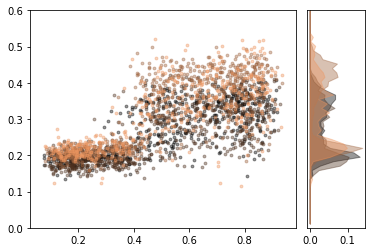

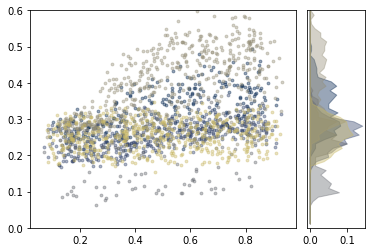

In [14]:
f,ax = plot_LAR(S1_rare,EM_rare,ymin=0,ymax=.6)
# f.savefig(os.path.join(basedir,'rare_sim1.pdf'),format='pdf')
f,ax = plot_LAR(S1_fam,EM_fam,cmap='cividis',ymin=0,ymax=.6)
# f.savefig(os.path.join(basedir,'fam_sim1.pdf'),format='pdf')

4
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4222168.1
(490,)


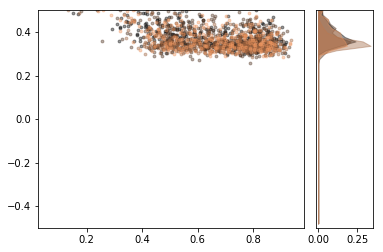

In [15]:
f,ax = plot_LAR(LAR_rare,EM_rare,cmap='copper',ymin=-.5,ymax=.5)
# f.savefig(os.path.join(basedir,'rare_simratio.pdf'),format='pdf')

4
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4222168.1
(490,)


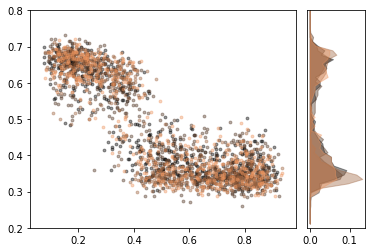

In [16]:
prob_rare = {}
for k in LAR_rare.keys():
    prob_rare[k] = np.array(S0_rare[k])/(np.array(S0_rare[k])+np.array(S1_rare[k]))

f,ax = plot_LAR(prob_rare,EM_rare,cmap='copper',ymin=0.2,ymax=.8)
# f.savefig(os.path.join(basedir,'rare_simprob.pdf'),format='pdf')

5
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(140,)
4222174.1
(565,)
4222154.1
(510,)


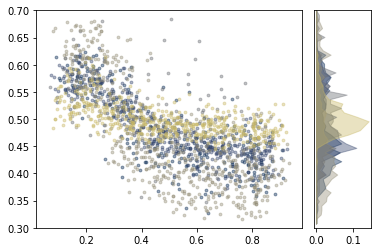

In [18]:

f,ax = plot_LAR(LAR_fam,EM_fam,cmap='cividis',ymin=.3,ymax=.7)
# f.savefig(os.path.join(basedir,'fam_simratio.pdf'),format='pdf')

5
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(140,)
4222174.1
(565,)
4222154.1
(510,)


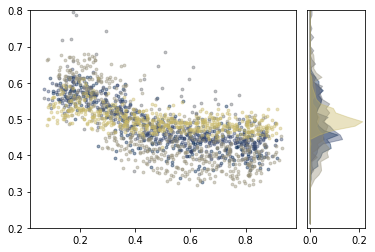

In [19]:
prob_fam = {}
for k in LAR_fam.keys():
#     if k != '4222154.1':
        prob_fam[k] = np.array(S0_fam[k])/(np.array(S0_fam[k])+np.array(S1_fam[k]))
    
f,ax = plot_LAR(prob_fam,EM_fam,cmap='cividis',ymin=0.2,ymax=.8)
# f.savefig(os.path.join(basedir,'fam_simprob.pdf'),format='pdf')

In [228]:

def mega_lar(LAR,exclude=()):
    mega_lar =  []
    for k,v in LAR.items():
        if k not in exclude:
            mega_lar.extend(v)
   
    return np.concatenate(mega_lar)


mega_lar_fam = mega_lar(LAR_fam)
mega_lar_rare = mega_lar(LAR_rare)

mega_prob_fam = mega_lar(prob_fam)
mega_prob_rare = mega_lar(prob_rare)

mega_em_fam = mega_lar(EM_fam)
mega_em_rare = mega_lar(EM_rare)

mega_s0_fam = mega_lar(S0_fam)
mega_s1_fam = mega_lar(S1_fam)

mega_s0_rare = mega_lar(S0_rare)
mega_s1_rare = mega_lar(S1_rare)



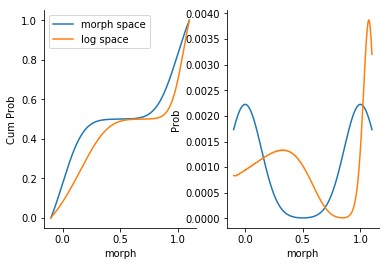

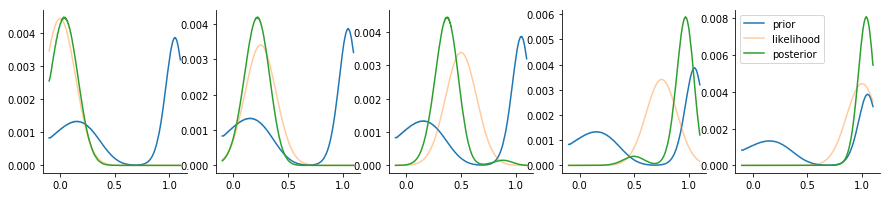

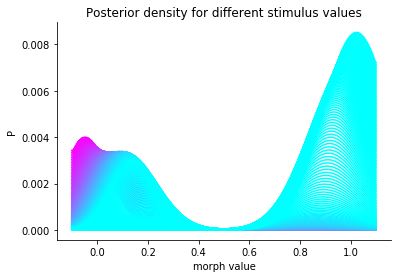

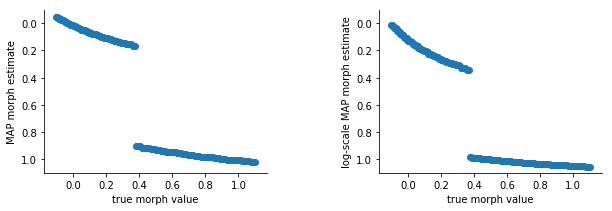

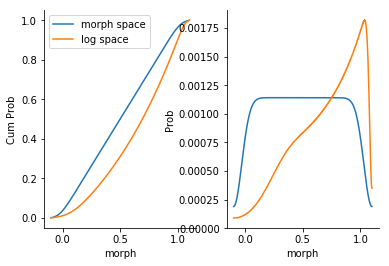

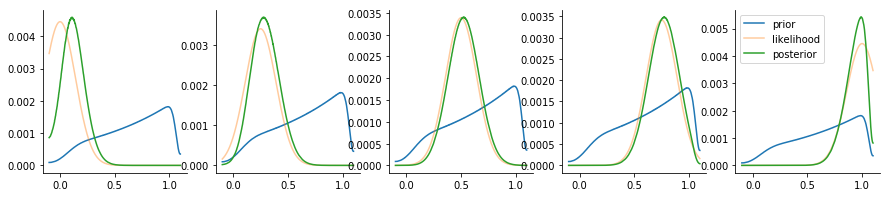

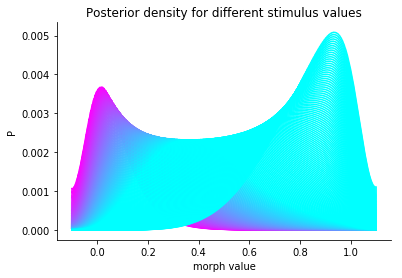

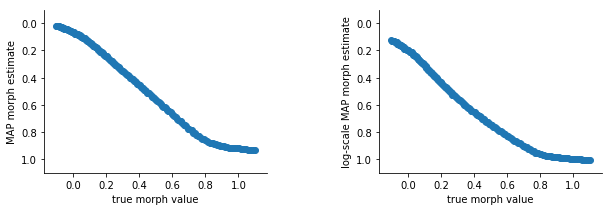

In [238]:
theta = np.linspace(-.1,1.1,num=200) # possible morph values
f1,f2 = 4, 12 # actual frequencies the mouse sees

mm = np.log10(f1*(1-theta) + f2*(theta)) # log of the linear combinations of the stimuli
# scale this so it's back in the range of the morph values without distortion
theta_corrected = (mm-np.amin(mm))/(np.amax(mm)-np.amin(mm))*1.2 - .1 
theta_corrected[0],theta_corrected[-1]=-.1,1.1 # hard code the edges to correct float errors

# splines for going between the two spaces
morph_2_logstim = spline(theta,theta_corrected)
logstim_2_morph = spline(theta_corrected,theta)

gaussian = lambda mu,sigma,x: np.exp(-(mu-x)**2/sigma**2)
unif = lambda mu, sigma, x: 1*(np.abs(x-mu)<=sigma/2)
def gaussian_dens(mu,sigma,x):
    v = gaussian(mu,sigma,x)
    return v/v.sum()

def mult_and_norm(dens1,dens2):
    post = dens1*dens2
    return post/post.sum()


def run_posterior_inference(p_theta,samp=np.linspace(-.1,1.1,num=1000)):
    '''function runs probabilistic inference and makes a few helpful plots
    Inputs: p_theta - the stimulus prior in log-space sampled at the values of previously defined theta
    Returns: figure and axes handles'''
    
    samp_mask = (samp>=-.1) & (samp<=1.1)
    ### RUN SOME DEMOS OF WHAT THE INFERENCE PROCESS LOOKS LIKE AT DIFFERENT STIMULUS VALUES
    
    # likelihood - zero centered gaussian with fixed variance in log space
    p_s_theta = gaussian_dens(0,.2,samp)

    # posterior - multiply likelihood and posterior and normalize to be a valid distribution
    p_theta_s = mult_and_norm(p_s_theta,p_theta)

    f_post_demo,ax_post_demo = plt.subplots(1,5,figsize=[15,3])
    ax_post_demo[0].plot(samp,p_theta,label='prior')
    ax_post_demo[0].plot(samp,p_s_theta,label='likelihood',alpha=.4)
    ax_post_demo[0].plot(samp,p_theta_s,label='posterior')
    
    ax_post_demo[0].spines['right'].set_visible(False)
    ax_post_demo[0].spines['top'].set_visible(False)
#     ax_post_demo[0].set_ylim([0,.05])
    # repeat above for a few other stimulus values
    for i,s in enumerate([.25,.5,.75,1]):
        # likelihood 
        p_s_theta = gaussian_dens(s,.2,samp)

        # posterior 
        p_theta_s = mult_and_norm(p_s_theta,p_theta)


        ax_post_demo[i+1].plot(samp[samp_mask],p_theta[samp_mask],label='prior')
        ax_post_demo[i+1].plot(samp[samp_mask],p_s_theta[samp_mask],label='likelihood',alpha=.4)
        ax_post_demo[i+1].plot(samp[samp_mask],p_theta_s[samp_mask],label='posterior')
        ax_post_demo[i+1].spines['right'].set_visible(False)
        ax_post_demo[i+1].spines['top'].set_visible(False)
#         ax_post_demo[i+1].set_ylim([0,.05])

    ax_post_demo[-1].legend()
    ### CALCULATE POSTERIOR AT RANGE OF STIMULUS VALUES AND PLOT
        
    f_post_dens,ax_post_dens = plt.subplots()
    ax_post_dens.spines['right'].set_visible(False)
    ax_post_dens.spines['top'].set_visible(False)
    theta_hat=[] # keep track of MAP estimate
    p_shat = [] # posterior at current value of stimulus
   
    for i,s in enumerate(theta): # sample log-spaced values
        p_s_theta = gaussian_dens(s,.3,samp) # likelihood
        p_theta_s = mult_and_norm(p_s_theta,p_theta) # posterior
        
        
        ax_post_dens.plot(logstim_2_morph(samp),p_theta_s,color=plt.cm.cool(1-i/100.)) # convert back from logspace
        theta_hat.append(samp[np.argmax(p_theta_s)]) # MAP estimate
#         theta_hat.append(p_theta_s[np.argmin(np.abs(samp))]*100.)
        p_shat.append((p_s_theta*p_theta).sum())

    ax_post_dens.set_ylabel('P')
    ax_post_dens.set_xlabel('morph value')
    ax_post_dens.set_title('Posterior density for different stimulus values')

    ## PLOT MAP ESTIMATE
    f_MAP,ax_MAP = plt.subplots(1,2,figsize=[10,3])
    f_MAP.subplots_adjust(wspace=.5)
    ax_MAP[0].spines['right'].set_visible(False)
    ax_MAP[0].spines['top'].set_visible(False)
    ax_MAP[0].scatter(logstim_2_morph(theta),logstim_2_morph(np.array(theta_hat)))
    ax_MAP[0].set_ylim([1.1,-.1])
    ax_MAP[0].set_ylabel('MAP morph estimate')
    ax_MAP[0].set_xlabel('true morph value')
    
    ax_MAP[1].spines['right'].set_visible(False)
    ax_MAP[1].spines['top'].set_visible(False)
    ax_MAP[1].scatter(logstim_2_morph(theta),np.array(theta_hat))
    ax_MAP[1].set_ylim([1.1,-.1])
    ax_MAP[1].set_ylabel('log-scale MAP morph estimate')
    ax_MAP[1].set_xlabel('true morph value')
    
    return np.array(theta_hat),(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP)


def convert_prior_to_log(prior,samp = np.linspace(-.1,1.1,num=1000)):
    '''convert a prior distribution in stimulus space to logspace for proper sampling
    Input: prior - arbitrary distribution assumed to be sampled in the range of values of theta variable
    Returns: log_dens - log space density for use with run_posterior_inference
             log_sampling_spline - log space cummulative distribution spline for sampling with kWTA_network_model (defined below)'''
    samp_mask = (samp>=-.1) & (samp<=1.1)
    # normalize to ensure prior is a proper distribution
    prior/=prior.sum()
    # go to cummulative distribution so that conversion maintains density
    cum_prior = np.cumsum(prior)
    cum_prior[0],cum_prior[-1] = 0,1 # correct for float errors
    cum_spline = spline(samp,cum_prior) # fit a linear interpolation spline so that we can arbitrarily sample
    log_cum_spline = spline(morph_2_logstim(samp),cum_prior)
    log_cum = log_cum_spline(samp) # sample cummulative distribution in log space
    log_sampling_spline = spline(cum_prior,morph_2_logstim(samp))  # create transposed spline for sampling values according to their probability
    
    f,ax = plt.subplots(1,2)
    
    
    for a in range(2):
        ax[a].spines['right'].set_visible(False)
        ax[a].spines['top'].set_visible(False)
        
    ax[0].plot(samp[samp_mask],cum_prior[samp_mask],label='morph space')
    ax[0].plot(morph_2_logstim(samp[samp_mask]),cum_prior[samp_mask],label='log space')
    ax[0].legend()
    ax[0].set_ylabel('Cum Prob')
    ax[0].set_xlabel('morph')
    
    ax[1].plot(samp[samp_mask],prior[samp_mask])
    #convert cumulative density back to density
    log_dens = log_cum[1:]-log_cum[:-1]
    log_dens[:10]= log_dens[10] # stretching at the end of the spline causes artifacts so we're just clamping those values 
    log_dens = np.append(log_dens,log_dens[-1])
    log_dens /=log_dens.sum()
    ax[1].plot(morph_2_logstim(samp[samp_mask]),log_dens[samp_mask])
    ax[1].set_ylabel('Prob')
    ax[1].set_xlabel('morph')
#     ax[1].set_ylim([0,.05])
    
    return log_dens, log_sampling_spline

samp = np.linspace(-.1,1.1,num=1000)
rare_prior = np.zeros(samp.shape)+.001
rare_prior = gaussian(0,.2,samp)+gaussian(1,.2,samp)
rare_prior /= rare_prior.sum()

rare_log_dens, rare_lcs = convert_prior_to_log(rare_prior)

rare_p_shat, (f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP) = run_posterior_inference(rare_log_dens)

# fam_prior = np.ones(samp.shape)
# fam_prior = gaussian(.5,.4,samp)
# fam_prior/=1000
# fam_prior += gaussian(.5,.9,samp)
fam_prior = np.ones(samp.shape)+.2
# fam_prior/=1000
fam_prior-=gaussian(-.1,.1,samp)
fam_prior-=gaussian(1.1,.1,samp)
fam_prior/=fam_prior.sum()


# fam_prior = np.zeros(samp.shape)
# for m in [0,.25,.5,.75,1.]:
#     fam_prior+=gaussian(m,.2,samp)
# fam_prior/=fam_prior.sum()


fam_log_dens, fam_lcs = convert_prior_to_log(fam_prior)

fam_p_shat,(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP) = run_posterior_inference(fam_log_dens)


In [239]:
import sklearn
from sklearn.model_selection import KFold
from scipy.optimize import curve_fit 

def sigmoid(x,x0,y0,c,k):
#     x0,y0,c,k=p
    y = c / (1 + np.exp(-k*(x-x0))) + y0
    return y

# def residuals(p,x,y):
#     return y - sigmoid(x,p)


In [240]:
mega_em_rare_orig = mega_em_rare*1.6-.3
mega_em_fam_orig = mega_em_fam*1.6-.3

edges = np.array([-.3,.125,.375,.625,.875,1.3])
hist,edges= np.histogram(mega_em_rare_orig,bins=edges)
print(hist)
# find indices that need to be downsampled
mask = np.ones(mega_em_rare_orig.shape)>0

hist,edges= np.histogram(mega_em_fam_orig,bins=edges)
print(hist)

[610 400 404 406 590]
[391 374 389 377 390]


C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estima

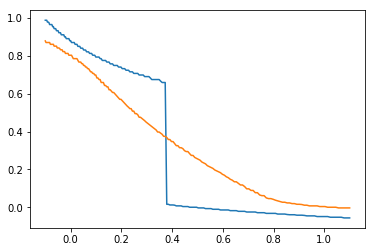

In [241]:
##
rare_map_spline = spline(logstim_2_morph(theta),rare_p_shat)
fam_map_spline = spline(logstim_2_morph(theta),fam_p_shat)
f,ax = plt.subplots()
ax.plot(logstim_2_morph(theta),1-rare_map_spline(logstim_2_morph(theta)))
ax.plot(logstim_2_morph(theta),1-fam_map_spline(logstim_2_morph(theta)))



mega_em_rare_n = (mega_em_rare-mega_em_rare.min())/(mega_em_rare.max()-mega_em_rare.min())*1.2 -.1
mega_em_fam_n = (mega_em_fam-mega_em_fam.min())/(mega_em_fam.max()-mega_em_fam.min())*1.2 -.1



rare_reg = linreg()
rare_reg.fit(rare_map_spline(mega_em_rare_n[:,np.newaxis]),mega_lar_rare)

rare_freg = linreg()
rare_freg.fit(fam_map_spline(mega_em_rare_n[:,np.newaxis]),mega_lar_rare)

rare_linreg = linreg()
rare_linreg.fit(mega_em_rare_n[:,np.newaxis],mega_lar_rare)

rare_sig_popt, pcov = curve_fit(sigmoid,mega_em_rare_n,mega_lar_rare) #,p0 = np.random.rand(4))
#rare_sig = sigmoid(mega_em_rare_n,*rare_sig_popt)
    


cviter = KFold(n_splits=100,shuffle=True)
rare_cv,rare_fcv,rare_linecv,rare_sigcv=[],[],[],[]
for _train,_test in cviter.split(mega_em_rare_n[:,np.newaxis]):
    _reg = linreg()
    _reg.fit(rare_map_spline(mega_em_rare_n[_train,np.newaxis]),mega_lar_rare[_train])
    _yhat=_reg.predict(rare_map_spline(mega_em_rare_n[_test,np.newaxis]))
    rare_cv.append(sklearn.metrics.mean_squared_error(mega_lar_rare[_test],_yhat))

    
    _freg = linreg()
    _freg.fit(fam_map_spline(mega_em_rare_n[_train,np.newaxis]),mega_lar_rare[_train])
    _yhat=_freg.predict(rare_map_spline(mega_em_rare_n[_test,np.newaxis]))
    rare_fcv.append(sklearn.metrics.mean_squared_error(mega_lar_rare[_test],_yhat))

    
    _lreg = linreg()
    _lreg.fit(mega_em_rare_n[_train,np.newaxis],mega_lar_rare[_train])
    _yhat=_lreg.predict(mega_em_rare_n[_test,np.newaxis])
    rare_linecv.append(sklearn.metrics.mean_squared_error(mega_lar_rare[_test],_yhat))

    
    popt, pcov = curve_fit(sigmoid,mega_em_rare_n[_train],mega_lar_rare[_train]) #,p0 = np.random.rand(4))
    _yhat = sigmoid(mega_em_rare_n[_test],*popt)
    rare_sigcv.append(sklearn.metrics.mean_squared_error(mega_lar_rare[_test],_yhat))

    

fam_reg = linreg()
fam_reg.fit(fam_map_spline(mega_em_fam[:,np.newaxis]),mega_lar_fam)

fam_rreg = linreg()
fam_rreg.fit(rare_map_spline(mega_em_fam[:,np.newaxis]),mega_lar_fam)

fam_linreg = linreg()
fam_linreg.fit(mega_em_fam_n[:,np.newaxis],mega_lar_fam)

fam_sig_popt, pcov = curve_fit(sigmoid,mega_em_fam_n,mega_lar_fam)

cviter = KFold(n_splits=100,shuffle=True)
fam_cv,fam_rcv,fam_linecv,fam_sigcv=[],[],[],[]
for _train,_test in cviter.split(mega_em_fam_n[:,np.newaxis]):
    _reg = linreg()
    _reg.fit(fam_map_spline(mega_em_fam_n[_train,np.newaxis]),mega_lar_fam[_train])
    _yhat=_reg.predict(fam_map_spline(mega_em_fam_n[_test,np.newaxis]))
    fam_cv.append(sklearn.metrics.mean_squared_error(mega_lar_fam[_test],_yhat))

    
    _rreg = linreg()
    _rreg.fit(rare_map_spline(mega_em_fam_n[_train,np.newaxis]),mega_lar_fam[_train])
    _yhat=_freg.predict(rare_map_spline(mega_em_fam_n[_test,np.newaxis]))
    fam_rcv.append(sklearn.metrics.mean_squared_error(mega_lar_fam[_test],_yhat))

    
    _lreg = linreg()
    _lreg.fit(mega_em_fam_n[_train,np.newaxis],mega_lar_fam[_train])
    _yhat=_lreg.predict(mega_em_fam_n[_test,np.newaxis])
    fam_linecv.append(sklearn.metrics.mean_squared_error(mega_lar_fam[_test],_yhat))

    
    popt, pcov = curve_fit(sigmoid,mega_em_fam_n[_train],mega_lar_fam[_train]) #,p0 = np.random.rand(4))
    _yhat = sigmoid(mega_em_fam_n[_test],*popt)
    fam_sigcv.append(sklearn.metrics.mean_squared_error(mega_lar_fam[_test],_yhat))

In [242]:
def model_comparison(em,lar):
    
    loo = sklearn.model_selection.LeaveOneOut()
    r_yhat,f_yhat,l_yhat,sig_yhat = np.zeros(em.shape),np.zeros(em.shape),np.zeros(em.shape),np.zeros(em.shape)
    for i,(_train,_test) in enumerate(loo.split(em)):
        r_reg  = linreg()
        r_reg.fit(rare_map_spline(em[_train,np.newaxis]),lar[_train])
        r_yhat[i]=(r_reg.predict(rare_map_spline(em[_test,np.newaxis]))-lar[_test])
    
        f_reg  = linreg()
        f_reg.fit(fam_map_spline(em[_train,np.newaxis]),lar[_train])
        f_yhat[i] =(f_reg.predict(fam_map_spline(em[_test,np.newaxis]))-lar[_test])
        
        l_reg  = linreg()
        l_reg.fit(em[_train,np.newaxis],lar[_train])
        l_yhat[i]=(l_reg.predict(rare_map_spline(em[_test,np.newaxis]))-lar[_test])
        
        popt, pcov = curve_fit(sigmoid,em[_train],lar[_train])
        sig_yhat[i] = (sigmoid(em[_test],*popt)-lar[_test])
   
    return r_yhat, f_yhat, l_yhat,sig_yhat

rare_cv_err = model_comparison(mega_em_rare_n,mega_lar_rare)
fam_cv_err = model_comparison(mega_em_fam_n,mega_lar_fam)

C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estima

In [243]:
EM_rare_n = {}
for k,v in EM_rare.items():
    EM_rare_n[k]=(v-mega_em_rare.min())/(mega_em_rare.max()-mega_em_rare.min())#*1.2-.1
# f,ax = plot_LAR(LAR_rare,EM_rare_n,cmap='copper',ymin=-.5,ymax=.5)
# ax[0].scatter(logstim_2_morph(theta),rare_reg.coef_*rare_p_shat + rare_reg.intercept_,color='orange')
# # f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\rare_LSR_MAP_regression.pdf",format='pdf')

4
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4222168.1
(490,)
0.0031896967202541477
0.003893867339176374
0.008239982072508352
0.0029202144128450615


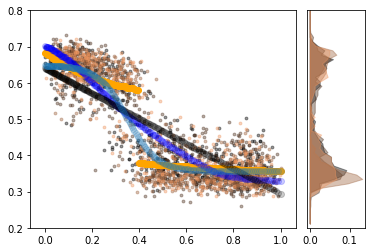

In [244]:
####CALCULATE ERROR AS A FUNCTION OF MORPH AND PLOT UNDER THESE PLOTS
f,ax = plot_LAR(LAR_rare,EM_rare_n,cmap='copper',ymin=.2,ymax=.8)
plot_theta = (logstim_2_morph(theta)+.1)/1.2
ax[0].scatter(plot_theta,rare_reg.coef_*rare_p_shat + rare_reg.intercept_,color='orange')
ax[0].scatter(plot_theta,rare_freg.coef_*fam_p_shat + rare_freg.intercept_,color='blue',alpha=.2)
ax[0].scatter(plot_theta,rare_linreg.predict(plot_theta[:,np.newaxis]),color='black',alpha=.2)
ax[0].scatter(plot_theta,sigmoid(plot_theta,*rare_sig_popt),alpha=.2)
print(np.mean(rare_cv_err[0]**2))
print(np.mean(rare_cv_err[1]**2))
print(np.mean(rare_cv_err[2]**2))
print(np.mean(rare_cv_err[3]**2))
# f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\rare_sf_MAP_regression.pdf",format='pdf')
# print(rare_cv['test_score'])
# print(rare_fcv['test_score'])

# f,ax = plt.subplots()
# bins = np.linspace(0,1,num=21)
# bin_inds = np.digitize(mega_em_rare,bins,right=True)
# err = np.zeros([4,20])
# for i in range(4):
#     for j in range(20):
#         mask = bin_inds==j
#         err[i,j]= (rare_cv_err[i][mask]**2).mean()

# ax.scatter(bins[1:],err[0,:],color='orange')
# ax.scatter(bins[1:],err[1,:],color='blue')
# ax.scatter(bins[1:],err[2,:],color='black')
# ax.scatter(bins[1:],err[3,:],color='red')

In [245]:
EM_fam_n = {}
for k,v in EM_fam.items():
    EM_fam_n[k]=(v-mega_em_fam.min())/(mega_em_fam.max()-mega_em_fam.min())#*1.2-.1
# f,ax = plot_LAR(LAR_fam,EM_fam_n,cmap='cividis',ymin=-.3,ymax=.3)
# ax[0].scatter(logstim_2_morph(theta),fam_reg.coef_*fam_p_shat + fam_reg.intercept_,color='blue')
# # f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\fam_LSR_MAP_regression.pdf",format='pdf')

5
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(140,)
4222174.1
(565,)
4222154.1
(510,)
0.002717983327115129
0.0025239548800909295
0.003929440151709212
0.005006463618011223


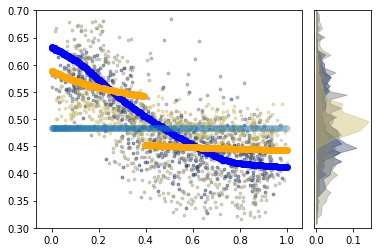

In [246]:
f,ax = plot_LAR(prob_fam,EM_fam_n,cmap='cividis',ymin=.3,ymax=.7)
ax[0].scatter(plot_theta,fam_reg.coef_*fam_p_shat + fam_reg.intercept_,color='blue')
ax[0].scatter(plot_theta,fam_rreg.coef_*rare_p_shat + fam_rreg.intercept_,color='orange')
# ax[0].scatter(plot_theta,fam_linreg.predict(plot_theta[:,np.newaxis]),color='black',alpha=.2)
ax[0].scatter(plot_theta,sigmoid(plot_theta,*fam_sig_popt),alpha=.2)
# f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\fam_sf_MAP_regression.pdf",format='pdf')

print(np.mean(fam_cv_err[0]**2))
print(np.mean(fam_cv_err[1]**2))
print(np.mean(fam_cv_err[2]**2))
print(np.mean(fam_cv_err[3]**2))

In [247]:
# compare curve fits

# 10 fold cross -validation

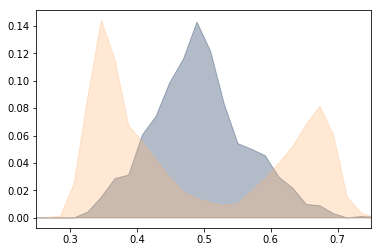

In [248]:
f,ax = plt.subplots()
bins = np.linspace(0,1)
fam_hist,edges = np.histogram(mega_prob_fam,bins)
rare_hist,edges = np.histogram(mega_prob_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))
ax.set_xlim([.25,.75])
f.savefig(os.path.join(basedir,'sf_hist.pdf'),format='pdf')

In [28]:
morph_bins = np.linspace(0,1,num=51)
mega_em_rare_bin = np.digitize(mega_em_rare,morph_bins,right=True)
mega_em_fam_bin = np.digitize(mega_em_fam,morph_bins,right=True)

em_ = morph_bins[1:]
rare_,rare_sig = np.zeros([50,]),np.zeros([50,])

fam_,fam_sig = np.zeros([50,]), np.zeros([50,])
for j in range(50):
    r_mask = mega_em_rare_bin==j
    if r_mask.sum()>0:
        rare_[j]= np.nanmean(mega_lar_rare[r_mask])
        rare_sig[j]=sp.stats.iqr(mega_lar_rare[r_mask])
    else:
        rare_[j]=np.nan
        rare_sig[j]=np.nan
    
    f_mask = mega_em_fam_bin==j
    if f_mask.sum()>0:
        fam_[j]= np.nanmedian(mega_lar_fam[f_mask])
        fam_sig[j]=sp.stats.iqr(mega_lar_fam[f_mask])
    else:
        fam_[j]=np.nan
        fam_sig[j]=np.nan

        
# r_a,r_b = np.percentile(rare_[~np.isnan(rare_)],5), np.percentile(rare_[~np.isnan(rare_)],95)
# f_a,f_b = np.percentile(fam_[~np.isnan(fam_)],5), np.percentile(fam_[~np.isnan(fam_)],95)

# rare_norm,fam_norm = (rare_-r_a)/(r_b-r_a),(fam_-f_a)/(f_b-f_a)
# rare_norm_sig,fam_norm_sig = np.zeros([50,]),np.zeros([50,])
# for j in range(50):
#     r_mask = mega_em_rare_bin==j
#     if r_mask.sum()>0:
#         rare_[j]= np.nanmedian(mega_lar_rare[r_mask])
#         rare_sig[j]=sp.stats.iqr(mega_lar_rare[r_mask])
#     else:
#         rare_[j]=np.nan
#         rare_sig[j]=np.nan
    
#     f_mask = mega_em_fam_bin==j
#     if f_mask.sum()>0:
#         fam_[j]= np.nanmedian(mega_lar_fam[f_mask])
#         fam_sig[j]=sp.stats.iqr(mega_lar_fam[f_mask])
#     else:
#         fam_[j]=np.nan
#         fam_sig[j]=np.nan
        

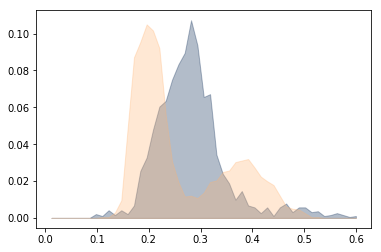

In [30]:
f,ax = plt.subplots()
bins = np.linspace(0,.6)
fam_hist,edges = np.histogram(mega_s0_fam,bins)
rare_hist,edges = np.histogram(mega_s0_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

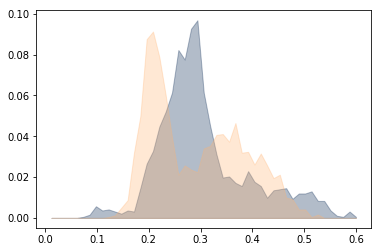

In [31]:
f,ax = plt.subplots()
bins = np.linspace(0,.6)
fam_hist,edges = np.histogram(mega_s1_fam,bins)
rare_hist,edges = np.histogram(mega_s1_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

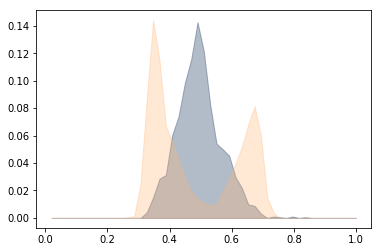

In [32]:
# plot distributions of absolute values and cdfs 
f,ax = plt.subplots()
bins = np.linspace(0,1)
fam_hist,edges = np.histogram(np.abs(mega_lar_fam),bins)
rare_hist,edges = np.histogram(np.abs(mega_lar_rare),bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

# f.savefig(os.path.join(basedir,'abs_lsr_hist.pdf'),format='pdf')

(49,)


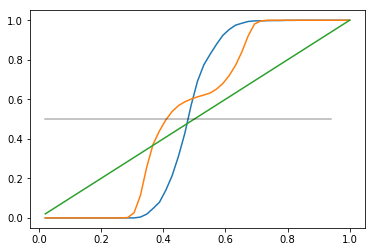

In [33]:
f,ax = plt.subplots()
print(fam_hist.shape)
fam_hist =fam_hist/fam_hist.sum()
rare_hist= rare_hist/rare_hist.sum()

ax.plot(bins[1:],np.cumsum(fam_hist))
ax.plot(bins[1:],np.cumsum(rare_hist))
ax.plot(bins[1:],bins[1:])
ax.plot(bins[1::5],.5*np.ones([10,]),alpha=.3,color='black')
# f.savefig(os.path.join(basedir,'abs_lsr_cdf.pdf'),format='pdf')


In [52]:
U,p = sp.stats.mannwhitneyu(np.abs(mega_prob_rare),np.abs(mega_prob_fam))
print(U,p)

1955993.0 8.403021848732339e-19


In [34]:
basedir = "G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures"

# LAR over sessions within mouse

In [253]:
def _plot_LAR_session(lar,em,color='red',ymin=.2,ymax=.8,f=None,gs=None,ax_scat = None,ax_hist=None):
    
    if f is None:
        f = plt.figure()
        gs = gridspec.GridSpec(1,5)
        ax_scat = f.add_subplot(gs[:,:4])
        ax_hist = f.add_subplot(gs[:,-1])
    
   
    bins = np.linspace(ymin,ymax,num=20)
    ax_scat.scatter(em,lar,color=color,alpha=.6,s=8)
    hist,edges = np.histogram(lar,bins=bins)
    ax_hist.fill_betweenx(edges[1:],hist/hist.sum(),color=color,alpha=.4)
#     ax_hist.hist(lar,bins=50,orientation='horizontal',color=color,alpha=.4,density=True)
    ax_hist.set_ylim([ymin,ymax])
    ax_scat.set_ylim([ymin,ymax])
    ax_hist.set_yticks([])
    return {'f':f,'ax_scat':ax_scat,'gs':gs,'ax_hist':ax_hist}

In [257]:

mouse = '4139265.3'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1403,4139265.3,10_02_2019,1,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...
1405,4139265.3,10_02_2019,3,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...
1433,4139265.3,12_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.3\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...
1455,4139265.3,15_02_2019,4,TwoTower_foraging,72,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.3\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...
1475,4139265.3,17_02_2019,2,TwoTower_foraging,81,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.3\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...
1495,4139265.3,19_02_2019,2,TwoTower_foraging,92,1,CA1,2019-02-19,G:\My Drive\VR_Data\TwoTower\4139265.3\19_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...
1513,4139265.3,21_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-21,G:\My Drive\VR_Data\TwoTower\4139265.3\21_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...
1522,4139265.3,22_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-22,G:\My Drive\VR_Data\TwoTower\4139265.3\22_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...
1531,4139265.3,23_02_2019,2,TwoTower_foraging,93,1,CA1,2019-02-23,G:\My Drive\VR_Data\TwoTower\4139265.3\23_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...
1537,4139265.3,24_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-24,G:\My Drive\VR_Data\TwoTower\4139265.3\24_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...


In [258]:
sess = df_mouse.iloc[2]
_lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)

num aberrant ttls 0.0
22392 (22392,) (22392, 21) 74301
(74301,) (74301, 21)


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0
(22392, 1973)


0


C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estima

0.003569235008690558
0.003948590381880736
0.01973382650242094
0.007796755430653343
1
0.0052035681632468965
0.005034093967427848
0.025342061166965687
0.0037398618391075804
2


C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estima

0.003345148443634424
0.003181684594711511
0.01627103862182939
0.0027763364340025612
3


C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estima

0.002707335038141122
0.0038652869320826536
0.015976434375392746
0.010185121592440246
4


C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.0032613837005086095
0.0037797541460787933
0.018026941614745304
0.0025388536639645437


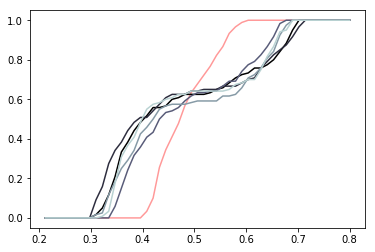

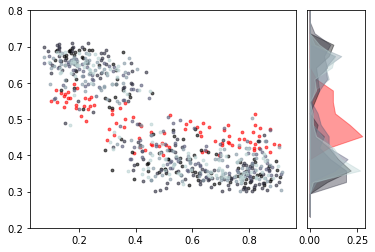

In [259]:
edges = np.linspace(.2,.8)


f_cdf,ax_cdf = plt.subplots()

hist,trsh = np.histogram(_lar,edges)
hist = hist/hist.sum()
ax_cdf.plot(edges[1:],np.cumsum(hist),color='red',alpha=.4)

fig_d = _plot_LAR_session(_lar,_em,color='red')

N = len(LAR_rare[mouse])
for sess, (lar,em) in enumerate(zip(LAR_rare[mouse],EM_rare[mouse])):
    print(sess)
    hist,trsh = np.histogram(lar,edges)
    hist=hist/hist.sum()
    ax_cdf.plot(edges[1:],np.cumsum(hist),color=plt.cm.bone(np.float(sess)/N))
    
    fig_d = _plot_LAR_session(lar,em,**fig_d,color=plt.cm.bone(np.float(sess)/N))
    sess_err = model_comparison(em,lar)
    for j in range(len(sess_err)):
        print(np.mean(sess_err[j]**2))
    
f_cdf.savefig(os.path.join(basedir,"%s_sess_lsr_cdf.pdf" % mouse),format='pdf')
fig_d['f'].savefig(os.path.join(basedir,"%s_sess_lsr.pdf" % mouse), format = 'pdf')

In [245]:
mouse = '4222153.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1724,4222153.1,08_04_2019,1,TwoTower_foraging,120,1,CA1,2019-04-08,G:\My Drive\VR_Data\TwoTower\4222153.1\08_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.1\08_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.1\08_04_2...
1747,4222153.1,10_04_2019,2,TwoTower_foraging,92,1,CA1,2019-04-10,G:\My Drive\VR_Data\TwoTower\4222153.1\10_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.1\10_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.1\10_04_2...
1768,4222153.1,12_04_2019,2,TwoTower_foraging,82,1,CA1,2019-04-12,G:\My Drive\VR_Data\TwoTower\4222153.1\12_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.1\12_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.1\12_04_2...
1794,4222153.1,14_04_2019,2,TwoTower_foraging,82,1,CA1,2019-04-14,G:\My Drive\VR_Data\TwoTower\4222153.1\14_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.1\14_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.1\14_04_2...
1803,4222153.1,15_04_2019,2,TwoTower_foraging,74,1,CA1,2019-04-15,G:\My Drive\VR_Data\TwoTower\4222153.1\15_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.1\15_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.1\15_04_2...
1813,4222153.1,16_04_2019,2,TwoTower_foraging,70,1,CA1,2019-04-16,G:\My Drive\VR_Data\TwoTower\4222153.1\16_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.1\16_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.1\16_04_2...
1822,4222153.1,17_04_2019,2,TwoTower_foraging,77,1,CA1,2019-04-17,G:\My Drive\VR_Data\TwoTower\4222153.1\17_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.1\17_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.1\17_04_2...


In [246]:
sess = df_mouse.iloc[1]
_lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)

num aberrant ttls 0.0
one frame correction
31722 (31722,) (31722, 21) 103701
(103701,) (103701, 21)
frame diff 0
(31722, 475)


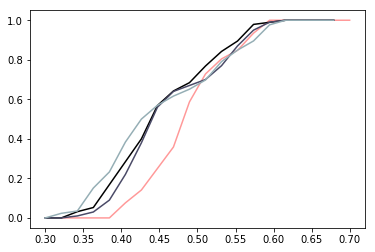

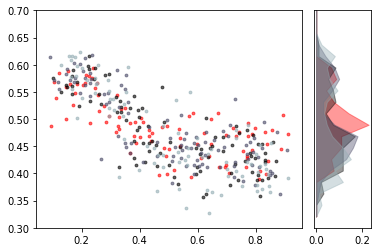

In [247]:
edges = np.linspace(0.30,.7,num=20)



f_cdf,ax_cdf = plt.subplots()

hist,trsh = np.histogram(_lar,edges)
hist = hist/hist.sum()
ax_cdf.plot(edges[1:],np.cumsum(hist),color='red',alpha=.4)

fig_d = _plot_LAR_session(_lar,_em,color='red',ymin=.3,ymax=.7)

N = len(LAR_fam[mouse])
for sess, (lar,em) in enumerate(zip(LAR_fam[mouse],EM_fam[mouse])):
    hist,trsh = np.histogram(lar,edges)
    hist=hist/hist.sum()
    ax_cdf.plot(edges[0:-1],np.cumsum(hist),color=plt.cm.bone(np.float(sess)/N))
    fig_d = _plot_LAR_session(lar,em,**fig_d,color=plt.cm.bone(np.float(sess)/N),ymin=.3,ymax=.7)
    
    
f_cdf.savefig(os.path.join(basedir,"%s_sess_lsr_cdf.pdf" % mouse),format='pdf')
fig_d['f'].savefig(os.path.join(basedir,"%s_sess_lsr.pdf" % mouse), format = 'pdf')

In [ ]:
edges = np.linspace(0,1)



f_cdf,ax_cdf = plt.subplots()

hist,trsh = np.histogram(_lar,edges)
hist = hist/hist.sum()
ax_cdf.plot(edges[1:],np.cumsum(hist),color='red')

fig_d = _plot_LAR_session(_lar,_em,color='red')

N = len(LAR_dg[mouse])
for sess, (lar,em) in enumerate(zip(LAR_dg[mouse],EM_dg[mouse])):
    hist,trsh = np.histogram(lar,edges)
    hist=hist/hist.sum()
    ax_cdf.plot(edges[1:],np.cumsum(hist),color=plt.cm.bone(np.float(sess)/N))
    fig_d = _plot_LAR_session(lar,em,**fig_d,color=plt.cm.bone(np.float(sess)/N),ymin=-.15,ymax=.15)
    
ax_cdf.set_xlim([-.2,.2])
# f_cdf.savefig(os.path.join(basedir,"%s_sess_lsr_cdf.pdf" % mouse),format='pdf')
# fig_d['f'].savefig(os.path.join(basedir,"%s_sess_lsr.pdf" % mouse), format = 'pdf')

num aberrant ttls 0.0
22392 (22392,) (22392, 21) 74301
(74301,) (74301, 21)
frame diff 0
(22392, 1973)
num aberrant ttls 0.0
13506 (13506,) (13506, 21) 45655
(45655,) (45655, 21)
frame diff 0
(13506, 1178)
num aberrant ttls 0.0
19948 (19948,) (19948, 21) 65960
(65960,) (65960, 21)
frame diff 0
(19948, 996)
num aberrant ttls 0.0
21698 (21698,) (21698, 21) 60178
(60178,) (60178, 21)
frame diff 0
(21698, 1237)


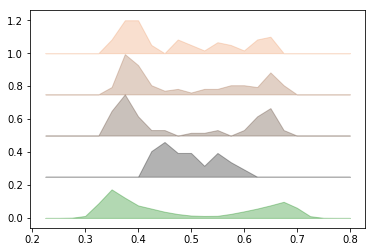

In [55]:
f,ax = plt.subplots()
bins = np.linspace(.2,.8,num=25)
rare_hist,edges = np.histogram(mega_lar_rare,bins)

ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color='green')

N =4
for i,mouse in enumerate(morph_rare):
    df_mouse = df[df['MouseName'].str.match(mouse)]
    if mouse == '4139268.1':
        sess = df_mouse.iloc[1]
    else:
        sess = df_mouse.iloc[2]
    _lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)
    _hist,edges = np.histogram(_lar,bins)
    ax.fill_between(edges[1:],_hist/_hist.sum() + (i+1)/4,y2=(i+1)/4,alpha=.3,color=plt.cm.copper(np.float(i/N)))
    
f.savefig(os.path.join(basedir,"sess3_v_latecomparison_rare.pdf"), format = 'pdf')

num aberrant ttls 0.0
one frame correction
31722 (31722,) (31722, 21) 103701
(103701,) (103701, 21)
frame diff 0
(31722, 475)
num aberrant ttls 0.0
35978 (35978,) (35978, 21) 119008
(119008,) (119008, 21)
frame diff 0
(35978, 2016)
num aberrant ttls 0.0
24296 (24296,) (24296, 21) 79674
(79674,) (79674, 21)
frame diff 0
(24296, 295)
num aberrant ttls 0.0
33583 (33583,) (33583, 21) 110386
(110386,) (110386, 21)
frame diff 0
(33583, 1965)
num aberrant ttls 0.0
26012 (26012,) (26012, 21) 85076
(85076,) (85076, 21)
frame diff 0
(26012, 591)


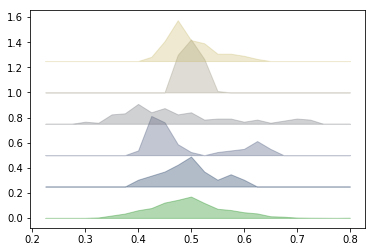

In [56]:
f,ax = plt.subplots()
bins = np.linspace(.2,.8,num=25)
fam_hist,edges = np.histogram(mega_lar_fam,bins)

ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color='green')

N =5
for i,mouse in enumerate(morph_familiar):
    df_mouse = df[df['MouseName'].str.match(mouse)]
    sess = df_mouse.iloc[1]
    _lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)
    _hist,edges = np.histogram(_lar,bins)
    ax.fill_between(edges[1:],_hist/_hist.sum()+(i+1)/4,y2=(i+1)/4,alpha=.3,color=plt.cm.cividis(np.float(i/N)))

f.savefig(os.path.join(basedir,"sess3_v_latecomparison_fam.pdf"), format = 'pdf')

# comparison with familar morph with discrimination

In [45]:
LAR_fd,EM_fd,S0_fd,S1_fd = LAR_list_maker(['4222157.4','4222169.1','4222169.2','4222169.4'],firstSess=2)

session ind 2
num aberrant ttls 0.0
24514 (24514,) (24514, 21) 69410
(69410,) (69410, 21)
frame diff 0
(24514, 1491)


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:334: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:333: RuntimeWarning: Mean of empty slice
  zone0_speed[i]=np.nanmean(sub_frame.loc[zone0_mask,'speed'])


session ind 3
num aberrant ttls 0.0
30893 (30893,) (30893, 21) 86929
(86929,) (86929, 21)
frame diff 0
(30893, 1428)
session ind 4
num aberrant ttls 0.0
26850 (26850,) (26850, 21) 75392
(75392,) (75392, 21)
frame diff 0
(26850, 1455)
session ind 5
num aberrant ttls 0.0
27977 (27977,) (27977, 21) 78367
(78367,) (78367, 21)
frame diff 0
(27977, 1371)
session ind 6
num aberrant ttls 0.0
30469 (30469,) (30469, 21) 85961
(85961,) (85961, 21)
frame diff 0
(30469, 1521)
session ind 7
num aberrant ttls 0.0
27484 (27484,) (27484, 21) 78628
(78628,) (78628, 21)
frame diff 0
(27484, 1367)
session ind 8
num aberrant ttls 0.0
24753 (24753,) (24753, 21) 71281
(71281,) (71281, 21)
frame diff 0
(24753, 1429)
session ind 9
num aberrant ttls 0.0
22270 (22270,) (22270, 21) 63586
(63586,) (63586, 21)
frame diff 0
(22270, 1472)
session ind 10
num aberrant ttls 0.0
21653 (21653,) (21653, 21) 60130
(60130,) (60130, 21)
frame diff 0
(21653, 1537)
session ind 11
num aberrant ttls 0.0
25328 (25328,) (25328, 21)

4
4222157.4
(1030,)
4222169.1
(797,)
4222169.2
(135,)
4222169.4
(800,)
4
4222157.4
(1030,)
4222169.1
(797,)
4222169.2
(135,)
4222169.4
(800,)


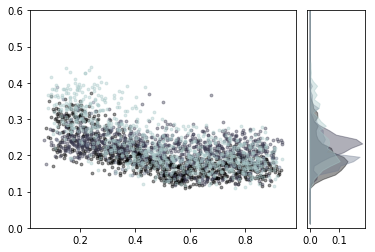

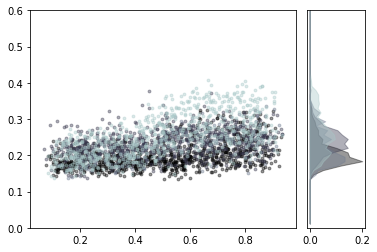

In [46]:
f,ax = plot_LAR(S0_fd,EM_fd,cmap='bone',ymin=0,ymax=.6)
# ax[0].set_ylim([0,.6])

f,ax = plot_LAR(S1_fd,EM_fd,cmap='bone',ymin=0,ymax=.6)
# ax[0].set_ylim([0,.6])

4
4222157.4
(1030,)
4222169.1
(797,)
4222169.2
(135,)
4222169.4
(800,)


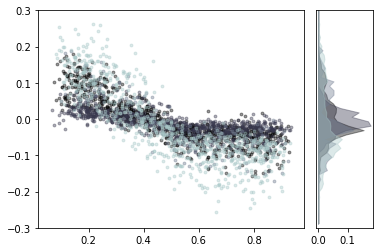

In [55]:
f,ax = plot_LAR(LAR_fd,EM_fd,cmap='bone',ymin=-.3,ymax=.3)
f.savefig(os.path.join(basedir,'fd_simratio.pdf'),format='pdf')



4
4222157.4
(1030,)
4222169.1
(797,)
4222169.2
(135,)
4222169.4
(800,)


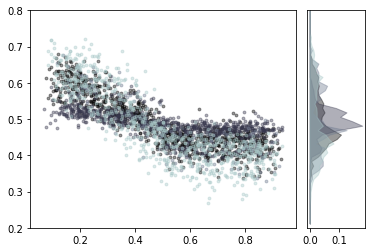

In [59]:
prob_fd = {}
for k in LAR_fd.keys():
    #if k != '4222154.1':
        prob_fd[k] = np.array(S0_fd[k])/(np.array(S0_fd[k])+np.array(S1_fd[k]))
        
f,ax = plot_LAR(prob_fd,EM_fd,cmap='bone',ymin=0.2,ymax=.8)

In [48]:
mega_lar_fd = mega_lar(LAR_fd)

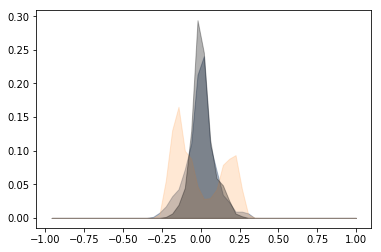

In [49]:
f,ax = plt.subplots()
bins = np.linspace(-1,1)
fam_hist,edges = np.histogram(mega_lar_fam,bins)
rare_hist,edges = np.histogram(mega_lar_rare,bins)
fd_hist,edges = np.histogram(mega_lar_fd,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))
ax.fill_between(edges[1:],fd_hist/fd_hist.sum(),alpha=.3,color=plt.cm.bone(0.))
f.savefig(os.path.join(basedir,'lsr_hist_fd.pdf'),format='pdf')

In [50]:
LAR_rd,EM_rd,S0_rd,S1_rd = LAR_list_maker(['4139224.2','4139224.3','4139224.5','4139219.1','4139219.3'],firstSess=5)

session ind 5
num aberrant ttls 0.0
26741 (26741,) (26741, 20) 83632
(83632,) (83632, 20)
frame diff 0
(26741, 1987)
session ind 6
num aberrant ttls 0.0
23611 (23611,) (23611, 20) 75002
(75002,) (75002, 20)
frame diff 0
(23611, 2069)
session ind 7
num aberrant ttls 0.0
28600 (28600,) (28600, 20) 90254
(90254,) (90254, 20)
frame diff 0
(28600, 1982)
session ind 8
num aberrant ttls 0.0
24063 (24063,) (24063, 20) 76746
(76746,) (76746, 20)
frame diff 0
(24063, 1837)
session ind 9
num aberrant ttls 0.0
27943 (27943,) (27943, 20) 90302
(90302,) (90302, 20)
frame diff 0
(27943, 1884)
session ind 5
num aberrant ttls 0.0
31376 (31376,) (31376, 20) 99274
(99274,) (99274, 20)
frame diff 0
(31376, 2100)
session ind 6
num aberrant ttls 0.0
29572 (29572,) (29572, 20) 92598
(92598,) (92598, 20)
frame diff 0
(29572, 1980)
session ind 7
num aberrant ttls 0.0
37977 (37977,) (37977, 20) 121175
(121175,) (121175, 20)
frame diff 0
(37977, 2009)
session ind 8
num aberrant ttls 0.0
32188 (32188,) (32188, 20

3
4139224.2
(449,)
4139224.3
(540,)
4139224.5
(623,)


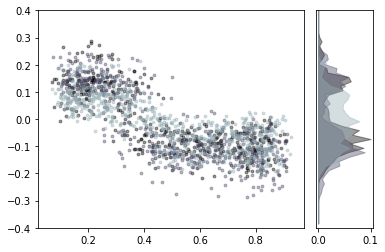

In [57]:
f,ax = plot_LAR(LAR_rd,EM_rd,cmap='bone',ymin=-.4,ymax=.4)

3
4139224.2
(449,)
4139224.3
(540,)
4139224.5
(623,)


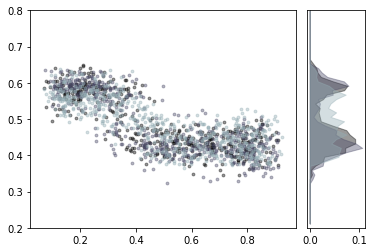

In [60]:
prob_rd = {}
for k in LAR_rd.keys():
    #if k != '4222154.1':
        prob_rd[k] = np.array(S0_rd[k])/(np.array(S0_rd[k])+np.array(S1_rd[k]))
        
f,ax = plot_LAR(prob_rd,EM_rd,cmap='bone',ymin=.2,ymax=.8)

In [52]:
LAR_dg, EM_dg, S0_df, S1_df = LAR_list_maker(['4222193.3'],firstSess=4)

session ind 4
num aberrant ttls 0.0
17258 (17258,) (17258, 21) 45680
(45680,) (45680, 21)
frame diff 0
(17258, 217)


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:122: RuntimeWarning: invalid value encountered in true_divide
  return frmap, occupancy/occupancy.ravel().sum()
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


session ind 5
num aberrant ttls 0.0
25985 (25985,) (25985, 21) 70127
(70127,) (70127, 21)
frame diff 0
(25985, 390)
session ind 6
num aberrant ttls 0.0
28101 (28101,) (28101, 21) 76551
(76551,) (76551, 21)
frame diff 0
(28101, 476)
session ind 7
num aberrant ttls 0.0
21828 (21828,) (21828, 21) 58775
(58775,) (58775, 21)
frame diff 0
(21828, 302)
session ind 8
num aberrant ttls 0.0
23445 (23445,) (23445, 21) 62964
(62964,) (62964, 21)
frame diff 0
(23445, 436)
session ind 9
num aberrant ttls 0.0
25905 (25905,) (25905, 21) 70033
(70033,) (70033, 21)
frame diff 0
(25905, 367)


1
4222193.3
(595,)


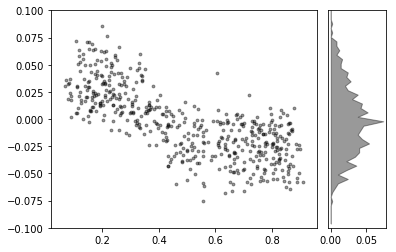

In [53]:
f,ax = plot_LAR(LAR_dg,EM_dg,cmap='bone',ymin=-.1,ymax=.1)